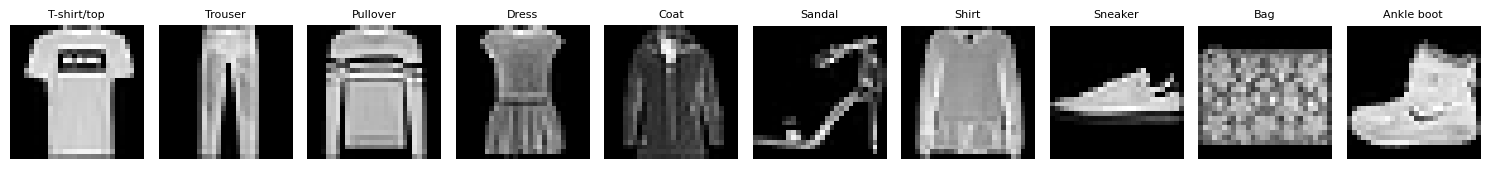

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Class labels from 0 to 9
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Create a figure with 10 subplots (1 row, 10 columns)
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

# Plot one image per class
for i in range(10):
    # Find the first occurrence of each class in train_labels
    idx = np.where(train_labels == i)[0][0]
    axes[i].imshow(train_images[idx], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(class_names[i], fontsize=8)

plt.tight_layout()
plt.show()

In [2]:
def split_train_validation(X, y, val_size=0.2):
    """Splits data into training and validation sets."""
    n = len(X)
    val_indices = np.random.choice(n, int(n * val_size), replace=False)
    train_indices = np.setdiff1d(np.arange(n), val_indices)
    
    return X[train_indices], X[val_indices], y[train_indices], y[val_indices]


In [3]:
# Normalize images to [0,1] range
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0

# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

# Activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss function (Cross-entropy)
def cross_entropy_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))


In [6]:
# Base Optimizer Class
class Optimizer:
    def update(self, params, grads):
        raise NotImplementedError

# Dictionary to store optimizers
optimizers = {}

def register_optimizer(name, optimizer_class):
    optimizers[name] = optimizer_class

# SGD Optimizer
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

register_optimizer('sgd', SGD)

# Momentum-based Gradient Descent
class Momentum(SGD):
    def __init__(self, lr=0.01, beta=0.9):
        super().__init__(lr)
        self.beta = beta
        self.v = {}
    
    def update(self, params, grads):
        for key in params.keys():
            if key not in self.v:
                self.v[key] = np.zeros_like(params[key])
            self.v[key] = self.beta * self.v[key] + (1 - self.beta) * grads[key]
            params[key] -= self.lr * self.v[key]

register_optimizer('momentum', Momentum)

# Nesterov Accelerated Gradient Descent
class NAG(Momentum):
    def update(self, params, grads):
        for key in params.keys():
            if key not in self.v:
                self.v[key] = np.zeros_like(params[key])
            prev_v = self.v[key]
            self.v[key] = self.beta * self.v[key] + self.lr * grads[key]
            params[key] -= self.beta * prev_v + (1 + self.beta) * self.v[key]

register_optimizer('nesterov', NAG)

# RMSprop Optimizer
class RMSprop(Optimizer):
    def __init__(self, lr=0.01, beta=0.9, epsilon=1e-8):
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        self.s = {}
    
    def update(self, params, grads):
        for key in params.keys():
            if key not in self.s:
                self.s[key] = np.zeros_like(params[key])
            self.s[key] = self.beta * self.s[key] + (1 - self.beta) * grads[key]**2
            params[key] -= self.lr * grads[key] / (np.sqrt(self.s[key]) + self.epsilon)

register_optimizer('rmsprop', RMSprop)

# Adam Optimizer
class Adam(Optimizer):
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0
    
    def update(self, params, grads):
        self.t += 1
        for key in params.keys():
            if key not in self.m:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key]**2)
            m_hat = self.m[key] / (1 - self.beta1**self.t)
            v_hat = self.v[key] / (1 - self.beta2**self.t)
            params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

register_optimizer('adam', Adam)


In [7]:
# Neural Network Class
class NeuralNetwork:
    def __init__(self, layers, activation='relu', optimizer='sgd', lr=0.01):
        self.layers = layers
        self.activation = activation
        self.params = {}
        self.grads = {}
        self.optimizer = optimizers[optimizer](lr=lr)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for i in range(len(self.layers) - 1):
            self.params[f'W{i+1}'] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.params[f'b{i+1}'] = np.zeros((1, self.layers[i+1]))
    
    def forward(self, X):
        self.cache = {'A0': X}
        for i in range(len(self.layers) - 1):
            Z = self.cache[f'A{i}'] @ self.params[f'W{i+1}'] + self.params[f'b{i+1}']
            self.cache[f'A{i+1}'] = relu(Z) if self.activation == 'relu' else sigmoid(Z)
        return softmax(self.cache[f'A{len(self.layers)-1}'])
    
    def backward(self, X, y):
        m = X.shape[0]
        dA = self.cache[f'A{len(self.layers)-1}'] - y
        for i in reversed(range(len(self.layers) - 1)):
            dZ = dA * relu_derivative(self.cache[f'A{i+1}'])
            self.grads[f'W{i+1}'] = self.cache[f'A{i}'].T @ dZ / m
            self.grads[f'b{i+1}'] = np.sum(dZ, axis=0, keepdims=True) / m
            dA = dZ @ self.params[f'W{i+1}'].T
        self.optimizer.update(self.params, self.grads)
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        for epoch in range(epochs):
            num_batches = X_train.shape[0] // batch_size
            for i in range(num_batches):
                start = i * batch_size
                end = start + batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                y_pred = self.forward(X_batch)
                loss = cross_entropy_loss(y_batch, y_pred)
                self.backward(X_batch, y_batch)

            # Evaluate on validation set
            y_val_pred = self.forward(X_val)
            val_loss = cross_entropy_loss(y_val, y_val_pred)

            # Log metrics to WandB
            wandb.log({"train_loss": loss, "val_loss": val_loss, "epoch": epoch + 1})
            print(f'Epoch {epoch+1}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')


In [8]:
import wandb
wandb.login(key="f56388c51b488c425a228537fd2d35e5498a3a91")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/sathwikpentela/.netrc
wandb: Currently logged in as: da24m017 (da24m017-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
sweep_config = {
    "method": "bayes",  # Can use 'grid' or 'bayes' for efficiency
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}


In [10]:
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_1")

Create sweep with ID: ic4mfnl6
Sweep URL: https://wandb.ai/da24m017-indian-institute-of-technology-madras/DA6401_Assignment_1/sweeps/ic4mfnl6


In [ ]:
def sweep_train():
    with wandb.init() as run:
        config = wandb.config

        # Load dataset
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        X_train, X_val, y_train, y_val = split_train_validation(X_train, y_train, val_size=0.2)

        # Normalize data
        X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

        # Flatten images (28x28 → 784)
        X_train, X_val, X_test = X_train.reshape(-1, 784), X_val.reshape(-1, 784), X_test.reshape(-1, 784)

        # Convert labels to one-hot encoding
        y_train = one_hot_encode(y_train, num_classes=10)
        y_val = one_hot_encode(y_val, num_classes=10)

        # Create model using wandb.config parameters
        model = NeuralNetwork(
            layers=[784] + [config.layer_size] * config.hidden_layers + [10],
            activation=config.activation,
            optimizer=config.optimizer,
            lr=config.learning_rate
        )

        # Train the model
        model.train(X_train, y_train, X_val, y_val, epochs=config.epochs, batch_size=config.batch_size)

        wandb.finish()


In [12]:
wandb.agent(sweep_id, function=sweep_train, count=50)

wandb: Agent Starting Run: utbrgtmt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run utbrgtmt errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run utbrgtmt errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Epoch 1, Train Loss: 2.3028, Val Loss: 2.3027
Epoch 2, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 3, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 4, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 5, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 6, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 7, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 8, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 9, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 10, Train Loss: 2.3027, Val Loss: 2.3026


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▄▃▂▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_loss,2.30271
val_loss,2.30262


wandb: Agent Starting Run: yust2dwi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.2949, Val Loss: 2.3027
Epoch 2, Train Loss: 2.2919, Val Loss: 2.3030
Epoch 3, Train Loss: 2.2907, Val Loss: 2.3031
Epoch 4, Train Loss: 2.2902, Val Loss: 2.3032
Epoch 5, Train Loss: 2.2899, Val Loss: 2.3033
Epoch 6, Train Loss: 2.2898, Val Loss: 2.3033
Epoch 7, Train Loss: 2.2898, Val Loss: 2.3033
Epoch 8, Train Loss: 2.2898, Val Loss: 2.3033
Epoch 9, Train Loss: 2.2898, Val Loss: 2.3033
Epoch 10, Train Loss: 2.2898, Val Loss: 2.3033


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▂▂▁▁▁▁▁▁
val_loss,▁▄▆▇██████
epoch,10
train_loss,2.28977
val_loss,2.30329


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: stmqmgqx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.3012, Val Loss: 2.3028
Epoch 2, Train Loss: 2.3012, Val Loss: 2.3027
Epoch 3, Train Loss: 2.3012, Val Loss: 2.3027


/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/3661820967.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 4, Train Loss: 2.3011, Val Loss: 2.3027
Epoch 5, Train Loss: 2.3011, Val Loss: 2.3027
Epoch 6, Train Loss: 2.3011, Val Loss: 2.3027
Epoch 7, Train Loss: 2.3011, Val Loss: 2.3027
Epoch 8, Train Loss: 2.3011, Val Loss: 2.3027
Epoch 9, Train Loss: 2.3011, Val Loss: 2.3027
Epoch 10, Train Loss: 2.3011, Val Loss: 2.3027


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▄▃▂▂▁▁
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_loss,2.30106
val_loss,2.30268


wandb: Agent Starting Run: 7iuwgtdh with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.3023, Val Loss: 2.3027
Epoch 2, Train Loss: 2.3021, Val Loss: 2.3029
Epoch 3, Train Loss: 2.3020, Val Loss: 2.3030
Epoch 4, Train Loss: 2.3020, Val Loss: 2.3032
Epoch 5, Train Loss: 2.3020, Val Loss: 2.3033


epoch,▁▃▅▆█
train_loss,█▄▂▁▁
val_loss,▁▃▅▇█
epoch,5
train_loss,2.30201
val_loss,2.30329


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gawy5fqv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.3030, Val Loss: 2.3026
Epoch 2, Train Loss: 2.3028, Val Loss: 2.3026
Epoch 3, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 4, Train Loss: 2.3027, Val Loss: 2.3026
Epoch 5, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 6, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 7, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 8, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 9, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 10, Train Loss: 2.3026, Val Loss: 2.3026


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▃▂▂▁▁▁▁
val_loss,▁▃▄▅▆▇▇▇██
epoch,10
train_loss,2.30255
val_loss,2.30259


wandb: Agent Starting Run: 90fdfk8i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.2104, Val Loss: 2.2045
Epoch 2, Train Loss: 2.1250, Val Loss: 2.0571
Epoch 3, Train Loss: 2.0532, Val Loss: 1.9832
Epoch 4, Train Loss: 1.9677, Val Loss: 1.9125
Epoch 5, Train Loss: 1.9318, Val Loss: 1.8703
Epoch 6, Train Loss: 1.9126, Val Loss: 1.8474
Epoch 7, Train Loss: 1.8997, Val Loss: 1.8324
Epoch 8, Train Loss: 1.8888, Val Loss: 1.8190
Epoch 9, Train Loss: 1.8827, Val Loss: 1.8106
Epoch 10, Train Loss: 1.8749, Val Loss: 1.8027


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▃▂▂▂▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_loss,1.87492
val_loss,1.80272


wandb: Agent Starting Run: h2xna525 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 1.9116, Val Loss: 1.8862
Epoch 2, Train Loss: 1.8638, Val Loss: 1.8303
Epoch 3, Train Loss: 1.8519, Val Loss: 1.8142
Epoch 4, Train Loss: 1.8309, Val Loss: 1.7916
Epoch 5, Train Loss: 1.8206, Val Loss: 1.7765
Epoch 6, Train Loss: 1.8061, Val Loss: 1.7618
Epoch 7, Train Loss: 1.8000, Val Loss: 1.7538
Epoch 8, Train Loss: 1.7933, Val Loss: 1.7474
Epoch 9, Train Loss: 1.7924, Val Loss: 1.7452
Epoch 10, Train Loss: 1.7866, Val Loss: 1.7399


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▅▃▃▂▂▁▁▁
val_loss,█▅▅▃▃▂▂▁▁▁
epoch,10
train_loss,1.7866
val_loss,1.73995


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ybqzqbrk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 1.9546, Val Loss: 1.9209
Epoch 2, Train Loss: 1.9233, Val Loss: 1.8820
Epoch 3, Train Loss: 1.8983, Val Loss: 1.8464
Epoch 4, Train Loss: 1.8689, Val Loss: 1.8153
Epoch 5, Train Loss: 1.8574, Val Loss: 1.7944
Epoch 6, Train Loss: 1.8568, Val Loss: 1.7845
Epoch 7, Train Loss: 1.8503, Val Loss: 1.7742
Epoch 8, Train Loss: 1.8231, Val Loss: 1.7700
Epoch 9, Train Loss: 1.8059, Val Loss: 1.7638
Epoch 10, Train Loss: 1.7850, Val Loss: 1.7531


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▄▄▄▄▃▂▁
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_loss,1.78502
val_loss,1.75306


wandb: Agent Starting Run: dlotiiac with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run dlotiiac errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run dlotiiac errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Epoch 1, Train Loss: 1.9521, Val Loss: 1.9721
Epoch 2, Train Loss: 1.8783, Val Loss: 1.8385
Epoch 3, Train Loss: 1.8394, Val Loss: 1.7864
Epoch 4, Train Loss: 1.8143, Val Loss: 1.7595
Epoch 5, Train Loss: 1.8003, Val Loss: 1.7452
Epoch 6, Train Loss: 1.7820, Val Loss: 1.7328
Epoch 7, Train Loss: 1.7723, Val Loss: 1.7275
Epoch 8, Train Loss: 1.7586, Val Loss: 1.7189
Epoch 9, Train Loss: 1.7402, Val Loss: 1.7113
Epoch 10, Train Loss: 1.7256, Val Loss: 1.7054


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
train_loss,1.72561
val_loss,1.70538


wandb: Agent Starting Run: zog0wtky with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run zog0wtky errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run zog0wtky errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Epoch 1, Train Loss: 2.0829, Val Loss: 1.9813
Epoch 2, Train Loss: 2.0247, Val Loss: 1.9294
Epoch 3, Train Loss: 2.0171, Val Loss: 1.9088
Epoch 4, Train Loss: 2.0068, Val Loss: 1.8895
Epoch 5, Train Loss: 2.0008, Val Loss: 1.8757
Epoch 6, Train Loss: 1.9871, Val Loss: 1.8650
Epoch 7, Train Loss: 1.9760, Val Loss: 1.8553
Epoch 8, Train Loss: 1.9668, Val Loss: 1.8467
Epoch 9, Train Loss: 1.9555, Val Loss: 1.8396
Epoch 10, Train Loss: 1.9453, Val Loss: 1.8362


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▅▄▄▃▃▂▂▁
val_loss,█▅▅▄▃▂▂▂▁▁
epoch,10
train_loss,1.94529
val_loss,1.83617


wandb: Agent Starting Run: dvue0egu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run dvue0egu errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run dvue0egu errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Epoch 1, Train Loss: 2.0244, Val Loss: 1.9849
Epoch 2, Train Loss: 1.9133, Val Loss: 1.8354
Epoch 3, Train Loss: 1.8898, Val Loss: 1.8020
Epoch 4, Train Loss: 1.8587, Val Loss: 1.7781
Epoch 5, Train Loss: 1.8307, Val Loss: 1.7614


epoch,▁▃▅▆█
train_loss,█▄▃▂▁
val_loss,█▃▂▂▁
epoch,5
train_loss,1.83071
val_loss,1.76138


wandb: Agent Starting Run: 4x0vqmpt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.2962, Val Loss: 2.3034
Epoch 2, Train Loss: 2.2960, Val Loss: 2.3034
Epoch 3, Train Loss: 2.2960, Val Loss: 2.3034
Epoch 4, Train Loss: 2.2960, Val Loss: 2.3034
Epoch 5, Train Loss: 2.2960, Val Loss: 2.3034


epoch,▁▃▅▆█
train_loss,█▁▁▁▁
val_loss,▁████
epoch,5
train_loss,2.29601
val_loss,2.30341


wandb: Agent Starting Run: 0zt36ssk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run 0zt36ssk errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run 0zt36ssk errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Epoch 1, Train Loss: 2.0799, Val Loss: 2.0506
Epoch 2, Train Loss: 1.8987, Val Loss: 1.9077
Epoch 3, Train Loss: 1.8310, Val Loss: 1.8439
Epoch 4, Train Loss: 1.7760, Val Loss: 1.7966
Epoch 5, Train Loss: 1.7558, Val Loss: 1.7782


epoch,▁▃▅▆█
train_loss,█▄▃▁▁
val_loss,█▄▃▁▁
epoch,5
train_loss,1.75577
val_loss,1.77821


wandb: Agent Starting Run: j62dycf6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.3020, Val Loss: 2.3026
Epoch 2, Train Loss: 2.3020, Val Loss: 2.3026
Epoch 3, Train Loss: 2.3020, Val Loss: 2.3027
Epoch 4, Train Loss: 2.3020, Val Loss: 2.3027
Epoch 5, Train Loss: 2.3020, Val Loss: 2.3027


epoch,▁▃▅▆█
train_loss,█▁▃▄▅
val_loss,▁▆███
epoch,5
train_loss,2.30198
val_loss,2.30265


wandb: Agent Starting Run: wzz63qwc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.0836, Val Loss: 2.0241
Epoch 2, Train Loss: 2.0412, Val Loss: 1.9764
Epoch 3, Train Loss: 2.0119, Val Loss: 1.9271
Epoch 4, Train Loss: 2.0073, Val Loss: 1.9104
Epoch 5, Train Loss: 2.0002, Val Loss: 1.9009
Epoch 6, Train Loss: 1.9936, Val Loss: 1.8921
Epoch 7, Train Loss: 1.9883, Val Loss: 1.8871
Epoch 8, Train Loss: 1.9793, Val Loss: 1.8783
Epoch 9, Train Loss: 1.9682, Val Loss: 1.8705
Epoch 10, Train Loss: 1.9581, Val Loss: 1.8635


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▄▄▃▃▃▂▂▁
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_loss,1.95813
val_loss,1.86349


wandb: Agent Starting Run: 4imnmeqh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.0374, Val Loss: 1.9532
Epoch 2, Train Loss: 1.9518, Val Loss: 1.9091
Epoch 3, Train Loss: 1.9210, Val Loss: 1.8877
Epoch 4, Train Loss: 1.9009, Val Loss: 1.8730
Epoch 5, Train Loss: 1.8833, Val Loss: 1.8631
Epoch 6, Train Loss: 1.8606, Val Loss: 1.8533
Epoch 7, Train Loss: 1.8574, Val Loss: 1.8440
Epoch 8, Train Loss: 1.8332, Val Loss: 1.8318
Epoch 9, Train Loss: 1.8223, Val Loss: 1.8286
Epoch 10, Train Loss: 1.8060, Val Loss: 1.8240


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▄▃▃▃▂▁▁
val_loss,█▆▄▄▃▃▂▁▁▁
epoch,10
train_loss,1.80603
val_loss,1.82403


wandb: Agent Starting Run: vgfj9wxj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 2, Train Loss: 2.3025, Val Loss: 2.3026
Epoch 3, Train Loss: 2.3025, Val Loss: 2.3026
Epoch 4, Train Loss: 2.3025, Val Loss: 2.3026
Epoch 5, Train Loss: 2.3025, Val Loss: 2.3026


epoch,▁▃▅▆█
train_loss,█▅▂▁▁
val_loss,▁▅▇██
epoch,5
train_loss,2.30253
val_loss,2.3026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ob6jyh5f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 1.9863, Val Loss: 1.9689
Epoch 2, Train Loss: 1.9401, Val Loss: 1.9042
Epoch 3, Train Loss: 1.9106, Val Loss: 1.8793
Epoch 4, Train Loss: 1.8983, Val Loss: 1.8685
Epoch 5, Train Loss: 1.8868, Val Loss: 1.8580
Epoch 6, Train Loss: 1.8751, Val Loss: 1.8463
Epoch 7, Train Loss: 1.8698, Val Loss: 1.8425
Epoch 8, Train Loss: 1.8598, Val Loss: 1.8350
Epoch 9, Train Loss: 1.8433, Val Loss: 1.8234
Epoch 10, Train Loss: 1.8320, Val Loss: 1.8142


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▃▃▂▂▁
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_loss,1.83199
val_loss,1.81424


wandb: Agent Starting Run: udy0ysqg with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run udy0ysqg errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run udy0ysqg errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Epoch 1, Train Loss: 2.0056, Val Loss: 1.9953
Epoch 2, Train Loss: 1.9613, Val Loss: 1.9105
Epoch 3, Train Loss: 1.9185, Val Loss: 1.8476
Epoch 4, Train Loss: 1.8690, Val Loss: 1.7830
Epoch 5, Train Loss: 1.8403, Val Loss: 1.7560
Epoch 6, Train Loss: 1.8232, Val Loss: 1.7380
Epoch 7, Train Loss: 1.8054, Val Loss: 1.7244
Epoch 8, Train Loss: 1.7877, Val Loss: 1.7109
Epoch 9, Train Loss: 1.7722, Val Loss: 1.7019
Epoch 10, Train Loss: 1.7485, Val Loss: 1.6920


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▄▄▃▃▂▂▁
val_loss,█▆▅▃▂▂▂▁▁▁
epoch,10
train_loss,1.74851
val_loss,1.69199


wandb: Agent Starting Run: bnsco452 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.0506, Val Loss: 2.0773
Epoch 2, Train Loss: 1.8528, Val Loss: 1.8115
Epoch 3, Train Loss: 1.7760, Val Loss: 1.7484
Epoch 4, Train Loss: 1.7459, Val Loss: 1.7280
Epoch 5, Train Loss: 1.7269, Val Loss: 1.7152
Epoch 6, Train Loss: 1.7113, Val Loss: 1.7077
Epoch 7, Train Loss: 1.7014, Val Loss: 1.6996
Epoch 8, Train Loss: 1.6857, Val Loss: 1.6903
Epoch 9, Train Loss: 1.6781, Val Loss: 1.6862
Epoch 10, Train Loss: 1.6672, Val Loss: 1.6794


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
train_loss,1.66723
val_loss,1.67935


wandb: Agent Starting Run: y5cs7awz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.3020, Val Loss: 2.3027
Epoch 2, Train Loss: 2.3019, Val Loss: 2.3027
Epoch 3, Train Loss: 2.3020, Val Loss: 2.3027
Epoch 4, Train Loss: 2.3021, Val Loss: 2.3027
Epoch 5, Train Loss: 2.3022, Val Loss: 2.3027


epoch,▁▃▅▆█
train_loss,▄▁▄▆█
val_loss,▄█▆▃▁
epoch,5
train_loss,2.30216
val_loss,2.30267


wandb: Agent Starting Run: mfofdgpi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.3024, Val Loss: 2.3025
Epoch 2, Train Loss: 2.3023, Val Loss: 2.3025
Epoch 3, Train Loss: 2.3021, Val Loss: 2.3025
Epoch 4, Train Loss: 2.3020, Val Loss: 2.3025
Epoch 5, Train Loss: 2.3019, Val Loss: 2.3025
Epoch 6, Train Loss: 2.3018, Val Loss: 2.3025
Epoch 7, Train Loss: 2.3017, Val Loss: 2.3024
Epoch 8, Train Loss: 2.3016, Val Loss: 2.3024
Epoch 9, Train Loss: 2.3015, Val Loss: 2.3024
Epoch 10, Train Loss: 2.3015, Val Loss: 2.3024


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▄▃▃▂▁▁
val_loss,█▆▅▃▃▂▁▁▁▁
epoch,10
train_loss,2.30145
val_loss,2.30244


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ii6j1p6x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.3025, Val Loss: 2.3026
Epoch 2, Train Loss: 2.3025, Val Loss: 2.3026
Epoch 3, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 4, Train Loss: 2.3025, Val Loss: 2.3026
Epoch 5, Train Loss: 2.3025, Val Loss: 2.3026


epoch,▁▃▅▆█
train_loss,▁▇███
val_loss,█▂▁▁▁
epoch,5
train_loss,2.30255
val_loss,2.30261


wandb: Agent Starting Run: ksqvp0mo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.3023, Val Loss: 2.3026
Epoch 2, Train Loss: 2.3024, Val Loss: 2.3026
Epoch 3, Train Loss: 2.3024, Val Loss: 2.3026
Epoch 4, Train Loss: 2.3024, Val Loss: 2.3026
Epoch 5, Train Loss: 2.3024, Val Loss: 2.3026


epoch,▁▃▅▆█
train_loss,▁████
val_loss,▁████
epoch,5
train_loss,2.30235
val_loss,2.3026


wandb: Agent Starting Run: df64mxwa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.0199, Val Loss: 2.0474
Epoch 2, Train Loss: 1.9941, Val Loss: 2.0024
Epoch 3, Train Loss: 1.9759, Val Loss: 1.9875
Epoch 4, Train Loss: 1.9589, Val Loss: 1.9717
Epoch 5, Train Loss: 1.9551, Val Loss: 1.9618
Epoch 6, Train Loss: 1.9419, Val Loss: 1.9514
Epoch 7, Train Loss: 1.9241, Val Loss: 1.9387
Epoch 8, Train Loss: 1.9079, Val Loss: 1.9282
Epoch 9, Train Loss: 1.8953, Val Loss: 1.9177
Epoch 10, Train Loss: 1.8794, Val Loss: 1.9113


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
train_loss,1.87938
val_loss,1.91134


wandb: Agent Starting Run: 8ji17kqi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.1445, Val Loss: 2.0799
Epoch 2, Train Loss: 2.1037, Val Loss: 2.0066
Epoch 3, Train Loss: 1.9956, Val Loss: 1.9243
Epoch 4, Train Loss: 1.9564, Val Loss: 1.8838
Epoch 5, Train Loss: 1.9133, Val Loss: 1.8526


epoch,▁▃▅▆█
train_loss,█▇▃▂▁
val_loss,█▆▃▂▁
epoch,5
train_loss,1.91334
val_loss,1.85262


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r8d4rkwc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run r8d4rkwc errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run r8d4rkwc errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Epoch 1, Train Loss: 2.0021, Val Loss: 2.0392
Epoch 2, Train Loss: 1.9459, Val Loss: 1.9276
Epoch 3, Train Loss: 1.9168, Val Loss: 1.8965
Epoch 4, Train Loss: 1.8943, Val Loss: 1.8833
Epoch 5, Train Loss: 1.8806, Val Loss: 1.8736
Epoch 6, Train Loss: 1.8699, Val Loss: 1.8612
Epoch 7, Train Loss: 1.8588, Val Loss: 1.8520
Epoch 8, Train Loss: 1.8482, Val Loss: 1.8454
Epoch 9, Train Loss: 1.8493, Val Loss: 1.8466
Epoch 10, Train Loss: 1.8416, Val Loss: 1.8413


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▄▃▃▂▂▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_loss,1.84163
val_loss,1.84134


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yvo58vie with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 1.8430, Val Loss: 1.8552
Epoch 2, Train Loss: 1.8024, Val Loss: 1.8104
Epoch 3, Train Loss: 1.7872, Val Loss: 1.8005
Epoch 4, Train Loss: 1.7819, Val Loss: 1.7958
Epoch 5, Train Loss: 1.7703, Val Loss: 1.7878


epoch,▁▃▅▆█
train_loss,█▄▃▂▁
val_loss,█▃▂▂▁
epoch,5
train_loss,1.77026
val_loss,1.78783


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z0swx700 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.0771, Val Loss: 2.0635
Epoch 2, Train Loss: 2.0113, Val Loss: 1.9677
Epoch 3, Train Loss: 1.9482, Val Loss: 1.9119
Epoch 4, Train Loss: 1.9124, Val Loss: 1.8664
Epoch 5, Train Loss: 1.8903, Val Loss: 1.8295


epoch,▁▃▅▆█
train_loss,█▆▃▂▁
val_loss,█▅▃▂▁
epoch,5
train_loss,1.89033
val_loss,1.82947


wandb: Agent Starting Run: zgdomedk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run zgdomedk errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run zgdomedk errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run tuf3kvu3 errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run tuf3kvu3 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run sn51aom5 errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run sn51aom5 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run 71r29tbf errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run 71r29tbf errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Epoch 1, Train Loss: 2.1257, Val Loss: 2.1317
Epoch 2, Train Loss: 1.9890, Val Loss: 1.9756
Epoch 3, Train Loss: 1.9185, Val Loss: 1.9015
Epoch 4, Train Loss: 1.8889, Val Loss: 1.8637
Epoch 5, Train Loss: 1.8713, Val Loss: 1.8465


epoch,▁▃▅▆█
train_loss,█▄▂▁▁
val_loss,█▄▂▁▁
epoch,5
train_loss,1.87131
val_loss,1.84648


wandb: Agent Starting Run: 16lpwmpz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.2374, Val Loss: 2.2547
Epoch 2, Train Loss: 2.1663, Val Loss: 2.1895
Epoch 3, Train Loss: 2.1288, Val Loss: 2.1574
Epoch 4, Train Loss: 2.0517, Val Loss: 2.0868
Epoch 5, Train Loss: 2.0136, Val Loss: 2.0512


epoch,▁▃▅▆█
train_loss,█▆▅▂▁
val_loss,█▆▅▂▁
epoch,5
train_loss,2.01362
val_loss,2.05121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vazebcgm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Train Loss: 1.9640, Val Loss: 1.9319
Epoch 2, Train Loss: 1.9375, Val Loss: 1.9033
Epoch 3, Train Loss: 1.9436, Val Loss: 1.9042
Epoch 4, Train Loss: 1.9244, Val Loss: 1.9021
Epoch 5, Train Loss: 1.9110, Val Loss: 1.8938


epoch,▁▃▅▆█
train_loss,█▄▅▃▁
val_loss,█▃▃▃▁
epoch,5
train_loss,1.91101
val_loss,1.89384


wandb: Agent Starting Run: c6174ags with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 1.9490, Val Loss: 1.9822
Epoch 2, Train Loss: 1.9384, Val Loss: 1.9687
Epoch 3, Train Loss: 1.9124, Val Loss: 1.9612
Epoch 4, Train Loss: 1.9170, Val Loss: 1.9546
Epoch 5, Train Loss: 1.9020, Val Loss: 1.9563


epoch,▁▃▅▆█
train_loss,█▆▃▃▁
val_loss,█▅▃▁▁
epoch,5
train_loss,1.90205
val_loss,1.95629


wandb: Agent Starting Run: 9b3ceco1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.3038, Val Loss: 2.3031
Epoch 2, Train Loss: 2.3039, Val Loss: 2.3032
Epoch 3, Train Loss: 2.3039, Val Loss: 2.3032
Epoch 4, Train Loss: 2.3039, Val Loss: 2.3032
Epoch 5, Train Loss: 2.3039, Val Loss: 2.3032


epoch,▁▃▅▆█
train_loss,▁▇███
val_loss,▁▇███
epoch,5
train_loss,2.30393
val_loss,2.30321


wandb: Agent Starting Run: gm3kws5f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.2363, Val Loss: 2.2366
Epoch 2, Train Loss: 2.0770, Val Loss: 2.0339
Epoch 3, Train Loss: 1.9735, Val Loss: 1.9357
Epoch 4, Train Loss: 1.8941, Val Loss: 1.8615
Epoch 5, Train Loss: 1.8442, Val Loss: 1.8199


epoch,▁▃▅▆█
train_loss,█▅▃▂▁
val_loss,█▅▃▂▁
epoch,5
train_loss,1.84416
val_loss,1.8199


wandb: Agent Starting Run: 8sq823ym with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train Loss: 2.1174, Val Loss: 2.1092
Epoch 2, Train Loss: 1.9675, Val Loss: 1.9931
Epoch 3, Train Loss: 1.9548, Val Loss: 1.9741
Epoch 4, Train Loss: 1.9470, Val Loss: 1.9644
Epoch 5, Train Loss: 1.9385, Val Loss: 1.9571
Epoch 6, Train Loss: 1.9293, Val Loss: 1.9496
Epoch 7, Train Loss: 1.9191, Val Loss: 1.9423
Epoch 8, Train Loss: 1.9121, Val Loss: 1.9378
Epoch 9, Train Loss: 1.9104, Val Loss: 1.9330
Epoch 10, Train Loss: 1.9075, Val Loss: 1.9274


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
train_loss,1.90755
val_loss,1.92735


wandb: Agent Starting Run: bqvbm34u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Traceback (most recent call last):
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'


Run bqvbm34u errored:
Traceback (most recent call last):
  File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
    model = NeuralNetwork(
  File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4163194409.py", line 8, in __init__
    self.optimizer = optimizers[optimizer](lr=lr)
KeyError: 'nadam'

wandb: ERROR Run bqvbm34u errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c9nd8xzdw00000gn/T/ipykernel_38811/4050847273.py", line 20, in sweep_train
wandb: ERROR     model = NeuralNetwork(
wandb: ERROR   File "/var/folders/97/64q5gb_55n5dk9c

Epoch 1, Train Loss: 1.9636, Val Loss: 2.0014
Epoch 2, Train Loss: 1.9387, Val Loss: 1.9509
Epoch 3, Train Loss: 1.9173, Val Loss: 1.9351
Epoch 4, Train Loss: 1.8975, Val Loss: 1.9200
Epoch 5, Train Loss: 1.8843, Val Loss: 1.9132


epoch,▁▃▅▆█
train_loss,█▆▄▂▁
val_loss,█▄▃▂▁
epoch,5
train_loss,1.88434
val_loss,1.91315


wandb: Agent Starting Run: s45snz7t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.0573, Val Loss: 2.0784
Epoch 2, Train Loss: 1.9712, Val Loss: 1.9610
Epoch 3, Train Loss: 1.9183, Val Loss: 1.9014
Epoch 4, Train Loss: 1.8688, Val Loss: 1.8520
Epoch 5, Train Loss: 1.8146, Val Loss: 1.8159
Epoch 6, Train Loss: 1.7795, Val Loss: 1.7920
Epoch 7, Train Loss: 1.7664, Val Loss: 1.7807
Epoch 8, Train Loss: 1.7546, Val Loss: 1.7758
Epoch 9, Train Loss: 1.7435, Val Loss: 1.7687
Epoch 10, Train Loss: 1.7267, Val Loss: 1.7637


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▂▂▂▁▁
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_loss,1.72674
val_loss,1.76369


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize images to [0,1] range
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0

# Define activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Base Optimizer Class
class Optimizer:
    def update(self, params, grads):
        raise NotImplementedError

# Optimizers Dictionary
optimizers = {}

def register_optimizer(name, optimizer_class):
    optimizers[name] = optimizer_class

# SGD Optimizer
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

register_optimizer('sgd', SGD)

# Momentum Optimizer
class Momentum(SGD):
    def __init__(self, lr=0.01, beta=0.9):
        super().__init__(lr)
        self.beta = beta
        self.v = {}
    
    def update(self, params, grads):
        for key in params.keys():
            if key not in self.v:
                self.v[key] = np.zeros_like(params[key])
            self.v[key] = self.beta * self.v[key] + (1 - self.beta) * grads[key]
            params[key] -= self.lr * self.v[key]

register_optimizer('momentum', Momentum)

# Nesterov Accelerated Gradient
class NAG(Momentum):
    def update(self, params, grads):
        for key in params.keys():
            if key not in self.v:
                self.v[key] = np.zeros_like(params[key])
            prev_v = self.v[key]
            self.v[key] = self.beta * self.v[key] + self.lr * grads[key]
            params[key] -= self.beta * prev_v + (1 + self.beta) * self.v[key]

register_optimizer('nesterov', NAG)

# RMSprop Optimizer
class RMSprop(Optimizer):
    def __init__(self, lr=0.01, beta=0.9, epsilon=1e-8):
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        self.s = {}
    
    def update(self, params, grads):
        for key in params.keys():
            if key not in self.s:
                self.s[key] = np.zeros_like(params[key])
            self.s[key] = self.beta * self.s[key] + (1 - self.beta) * grads[key]**2
            params[key] -= self.lr * grads[key] / (np.sqrt(self.s[key]) + self.epsilon)

register_optimizer('rmsprop', RMSprop)

# Adam Optimizer
class Adam(Optimizer):
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0
    
    def update(self, params, grads):
        self.t += 1
        for key in params.keys():
            if key not in self.m:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key]**2)
            m_hat = self.m[key] / (1 - self.beta1**self.t)
            v_hat = self.v[key] / (1 - self.beta2**self.t)
            params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

register_optimizer('adam', Adam)

# Neural Network Class
class FeedforwardNN:
    def __init__(self, input_size, hidden_layers, output_size, activation='relu', optimizer='sgd', lr=0.01):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.params = {}
        self.activation = activation
        self.activations = {'relu': (relu, relu_derivative), 'sigmoid': (sigmoid, sigmoid_derivative), 'tanh': (tanh, tanh_derivative)}
        self.optimizer = optimizers.get(optimizer, SGD)(lr)
        
        # Initialize weights and biases
        for i in range(len(self.layers) - 1):
            self.params[f'W{i+1}'] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.params[f'b{i+1}'] = np.zeros((1, self.layers[i+1]))
    
    def forward(self, X):
        self.cache = {'A0': X}
        A = X
        for i in range(len(self.layers) - 2):
            Z = np.dot(A, self.params[f'W{i+1}']) + self.params[f'b{i+1}']
            A = self.activations[self.activation][0](Z)
            self.cache[f'A{i+1}'] = A
        Z_out = np.dot(A, self.params[f'W{len(self.layers)-1}']) + self.params[f'b{len(self.layers)-1}']
        A_out = softmax(Z_out)
        self.cache[f'A{len(self.layers)-1}'] = A_out
        return A_out
    
    def backward(self, X, Y):
        m = X.shape[0]
        grads = {}
        A_out = self.cache[f'A{len(self.layers)-1}']
        dZ = A_out - Y
        
        for i in reversed(range(len(self.layers) - 1)):
            grads[f'W{i+1}'] = np.dot(self.cache[f'A{i}'].T, dZ) / m
            grads[f'b{i+1}'] = np.sum(dZ, axis=0, keepdims=True) / m
            if i > 0:
                dZ = np.dot(dZ, self.params[f'W{i+1}'].T) * self.activations[self.activation][1](self.cache[f'A{i}'])
        
        self.optimizer.update(self.params, grads)

# Example Usage
nn = FeedforwardNN(input_size=784, hidden_layers=[128, 64], output_size=10, activation='relu', optimizer='adam', lr=0.001)
